In [1]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Plot ROC graph
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

/home/kiki/anaconda3/envs/tfgpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-23 00:04:53.905767: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 00:04:53.942294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 00:04:54.388187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

<h2>Load data and DistilBERT word embeddings</h2>

In [2]:
base_directory = "./data/"
base_model_directory = "./models/"
def get_distilbert_embeddings(data, tokenizer, model, batch_size=32, max_length=110):
    # Placeholder for the embeddings
    all_embeddings = []

    for i in range(0, len(data), batch_size):
        batch = data.iloc[i:i+batch_size]
        batch['Claim'] = batch['Claim'].fillna('')
        batch['Evidence'] = batch['Evidence'].fillna('')
        texts = list(batch['Claim'] + " [SEP] " + batch['Evidence'])
        inputs = tokenizer.batch_encode_plus(texts, padding='max_length', truncation=True, return_tensors="tf", max_length=max_length)

        # Generate embeddings
        outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
        # Use the last_hidden_state so compatible with LSTM
        embeddings = outputs.last_hidden_state.numpy()
        all_embeddings.append(embeddings)


    # Concatenate all batch embeddings into a single array
    return np.vstack(all_embeddings)

def get_evaluation_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  print(f'Accuracy: {accuracy:.4f}')
  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1 Score: {f1:.4f}')

In [3]:
# Load test
test_data = pd.read_csv(base_directory + "dev.csv", encoding='utf-8') # Change later
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Remove [REF] from evidence
test_data['Evidence'] = test_data['Evidence'].str.replace('\[REF\]', '', regex=True)

# Create embeddings
test_embeddings_lr = get_distilbert_embeddings(test_data, tokenizer, model, max_length=110)
test_embeddings_lstm = get_distilbert_embeddings(test_data, tokenizer, model, max_length=70)
# Flatten embeddings
test_embeddings_lr_flat = test_embeddings_lr.reshape(test_embeddings_lr.shape[0], -1)

2024-04-23 00:05:11.002160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 00:05:11.113920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 00:05:11.113959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 00:05:11.117278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 00:05:11.117315: I tensorflow/compile

<h2>Logistic Regression Model</h2>

In [4]:
# Load PKL Model
lr_model = joblib.load(base_model_directory + "lr_model.pkl")

# Predict
lr_predictions = lr_model.predict(test_embeddings_lr_flat)

# Get evaluation metrics
get_evaluation_metrics(test_data['label'], lr_predictions)

Accuracy: 0.8210
Precision: 0.6813
Recall: 0.6323
F1 Score: 0.6559


<h2>LSTM Model</h2>

In [5]:
# Load model
lstm_model = load_model(base_model_directory + "lstm_ref_aug")

In [6]:
# Predict
lstm_predictions = lstm_model.predict(test_embeddings_lstm)
predictions_binary = np.where(lstm_predictions > 0.6, 1, 0)

# Get evaluation metrics
get_evaluation_metrics(test_data['label'], predictions_binary)

186/186 [==============================] - 10s 53ms/step
Accuracy: 0.8480
Precision: 0.7507
Recall: 0.6535
F1 Score: 0.6988


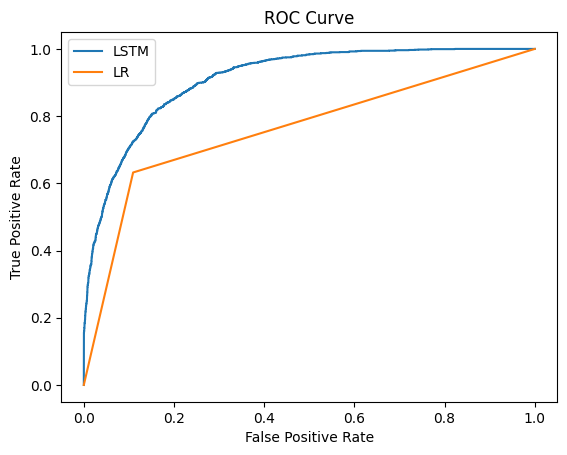

In [7]:


fpr_lstm, tpr_lstm, _ = roc_curve(test_data['label'], lstm_predictions)
fpr_lr, tpr_lr, _ = roc_curve(test_data['label'], lr_predictions)

plt.plot(fpr_lstm, tpr_lstm, label='LSTM')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
